# EECS 4422 Assignment 3

Jimmy Le<br>
216143992<br>
Prof. Kosta Derpanis<br>
EECS4422 W2023

## Tasks:

o Implement RANSAC based image stitching<br>
o Implement Panorama Construction<br>

## Import Libraries

In [572]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np
import cv2
import torch
import torch.nn as nn
import os
import kornia
import random
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE" #Prevents an unusual error where displaying images will crash the kernel?
#rcParams['figure.figsize'] = 11,8
plt.gray() #Ensures greyscale images are displayed gray without having to use cmap parameter

<Figure size 432x288 with 0 Axes>

## Functions

In [573]:
#Displays Tensors as image
def imshowTorch(input):
    image = kornia.tensor_to_image(input) #Converts to HWC format
    plt.imshow(image) #As matplotlib requires arrays 

In [574]:
#Converts numpy arrays to Kornia compatable tensors
def toKornia(img):
    print(img.shape)
    img = kornia.image_to_tensor(img) #Kornia in shape BCHW
    print(img.shape)
    # #Adding in dummy axis from: https://sparrow.dev/adding-a-dimension-to-a-tensor-in-pytorch/
    # img = torch.unsqueeze(img, dim=0)
    print(img.shape)
    return img

In [575]:
#Converts images to grayscale
# Implented during in class labs
def img2grayscale(img):
    # img = img.astype(np.float32)/255
    # img = (img[:,:,0]+ img[:,:,1]+ img[:,:,2]) / 3
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    return img

In [576]:
#From https://stackoverflow.com/questions/43391205/add-padding-to-images-to-get-them-into-the-same-shape
#Image padding from Lab 2,4
def pad_images_to_same_size(images):
    """
    :param images: sequence of images
    :return: list of images padded so that all images have same width and height (max width and height are used)
    """
    width_max = 0
    height_max = 0
    for img in images:
        h, w = img.shape[:2]
        width_max = max(width_max, w)
        height_max = max(height_max, h)

    images_padded = []
    for img in images:
        h, w = img.shape[:2]
        diff_vert = height_max - h
        pad_top = diff_vert//2
        pad_bottom = diff_vert - pad_top
        diff_hori = width_max - w
        pad_left = diff_hori//2
        pad_right = diff_hori - pad_left
        img_padded = cv2.copyMakeBorder(img, pad_top, pad_bottom, pad_left, pad_right, cv2.BORDER_CONSTANT, value=0)
        assert img_padded.shape[:2] == (height_max, width_max)
        images_padded.append(img_padded)

    return images_padded

In [577]:
def geometricDistance(pair, h):

    p1 = np.transpose(np.matrix([pair[0], pair[1], 1]))
    estimatep2 = np.dot(h, p1)
    estimatep2 = (1/estimatep2.item(2))*estimatep2

    p2 = np.transpose(np.matrix([pair[2], pair[3], 1]))
    error = p2 - estimatep2
    return np.linalg.norm(error)

In [578]:
def homography(points):
    points = np.reshape(points, (4,1))
    matrix = []

    for i in points:
        p1 = [points[0],points[1],1]
        p2 = [points[2],points[3],1]
        a1 = [-p2[2] * p1[0], -p2[2] * p1[1], -p2[2] * p1[2], 0, 0, 0, p2[0] * p1[0], p2[0] * p1[0], p2[0] * p1[2]]
        matrix.append(a1)
        a2 = [0, 0, 0, -p2[2] * p1[0], -p2[2] * p1[1], -p2[2] * p1[2], p2[1] * p1[0], p2[1] * p1[1], p2[1] * p1[2]]
        matrix.append(a2)
    
    matrix = np.asarray(matrix, dtype=float)
    u, s, v = np.linalg.svd(matrix)

    result = np.reshape(v[8], (3, 3))

    #normalize and now we have h
    #print(type(result))
    result = (1/result[2][2]) * result
    #print(type(result))

    return result

In [579]:
import matplotlib.pyplot as plt
import numpy as np


# Provided code for plotting inlier matches between two images

def plot_inlier_matches(ax, img1, img2, inliers):
    """
    Plot the matches between two images according to the matched keypoints
    :param ax: plot handle
    :param img1: left image
    :param img2: right image
    :inliers: x,y in the first image and x,y in the second image (Nx4)
    """
    res = np.hstack([img1, img2])
    ax.set_aspect('equal')
    ax.imshow(res, cmap='gray')
    
    ax.plot(inliers[:,0], inliers[:,1], '+r')
    ax.plot(inliers[:,2] + img1.shape[1], inliers[:,3], '+r')
    ax.plot([inliers[:,0], inliers[:,2] + img1.shape[1]],
            [inliers[:,1], inliers[:,3]], 'r', linewidth=0.4)
    ax.axis('off')
    
# Usage:
# fig, ax = plt.subplots(figsize=(20,10))
# plot_inlier_matches(ax, img1, img2, computed_inliers)


In [580]:
#Intuition: Kosta's lecture notes & provided example: tinyurl.com/RANSAC-demo (slide 456 of Feature Detection)
def RANSAC(matched,rho):
    
    bestModel = None
    #bestScore = Math.inf 
    bestInliers = []
    inliers = []
    #rand = random.randint(0, matched.shape[0]-1)
    #For a sufficent number of iterations   
    for i in range(2000):
        points = [random.randint(0,matched.shape[0]-1) for k in range(4)]
        h = homography(points)       
        #print(type(h))
        inliers = []

        for j in matched:
            d = geometricDistance(j,h)
            if d < 5:
                inliers.append(j)
        
        if len(inliers) > len(bestInliers):
            bestInliers = inliers
            bestModel = h

        if len(bestInliers) > (len(matched)*rho):
            break
    
    return bestModel, bestInliers


    #return h

## PART A

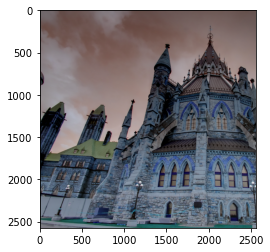

In [581]:
#Read in left
imgLeft = cv2.imread('parliament-left.jpg')
plt.imshow(imgLeft)

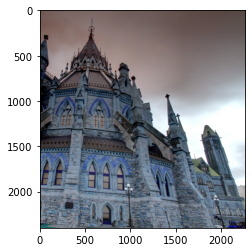

In [582]:
#Read in right
imgRight = cv2.imread('parliament-right.jpg')
plt.imshow(imgRight)

In [583]:
imgLeft, imgRight = pad_images_to_same_size([imgLeft, imgRight])

In [584]:
# imgLeft, imgRight = padImage(imgLeft, imgRight)

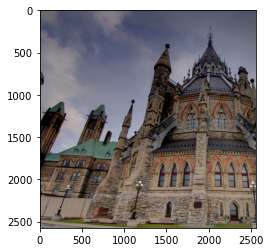

In [585]:
#Convert to rgb
imgLeft = cv2.cvtColor(imgLeft, cv2.COLOR_BGR2RGB)
plt.imshow(imgLeft)

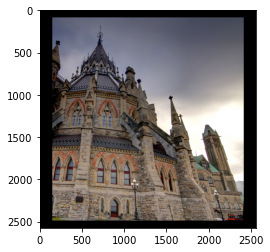

In [586]:
#Convert to rgb
imgRight = cv2.cvtColor(imgRight, cv2.COLOR_BGR2RGB)
plt.imshow(imgRight)

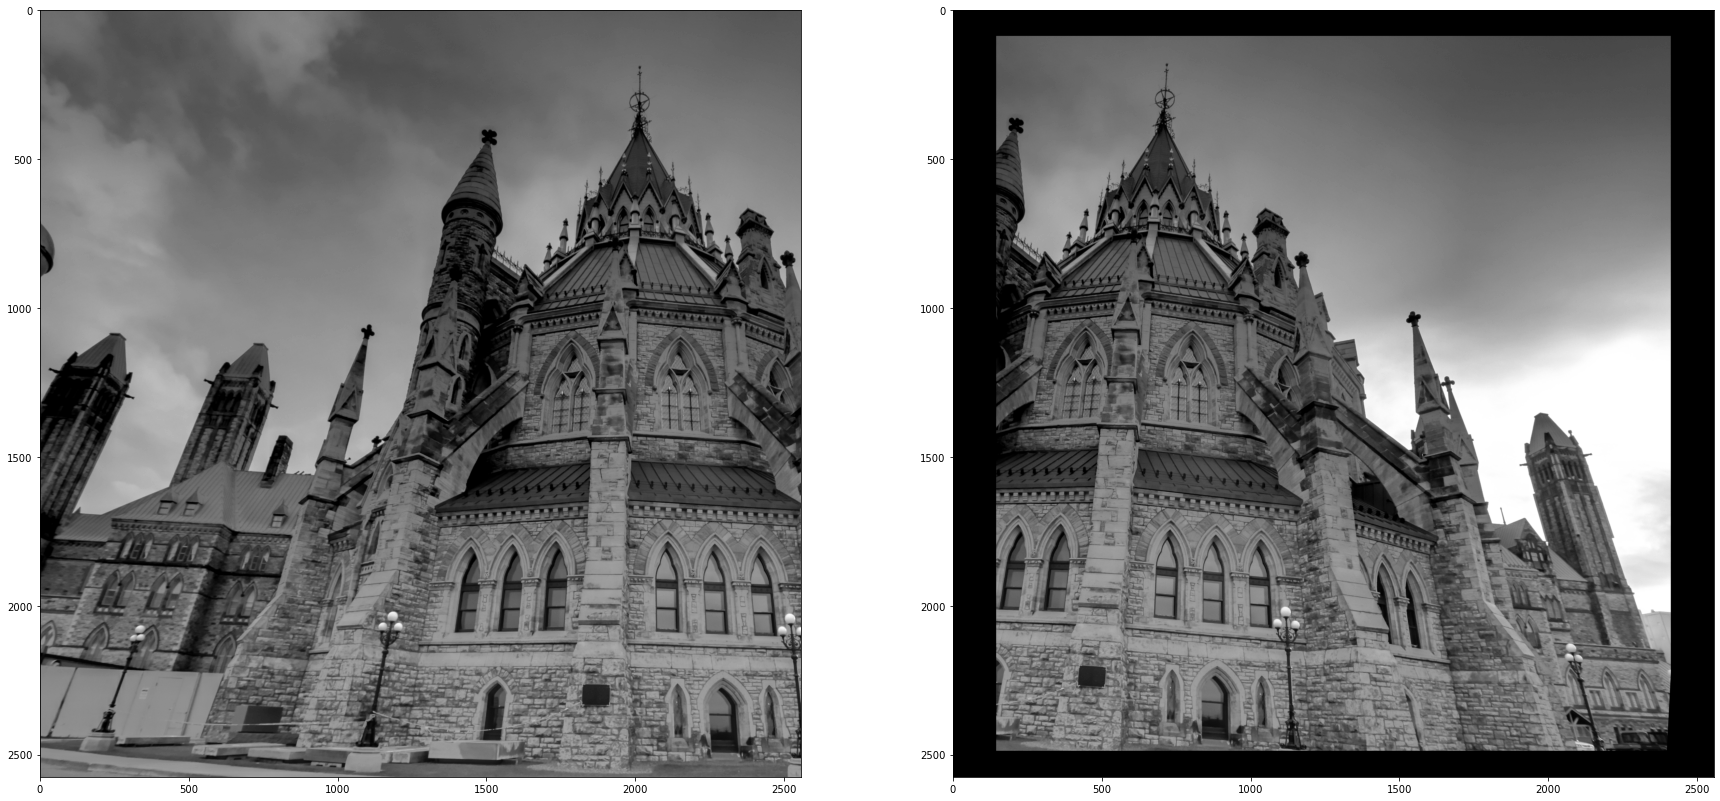

In [587]:
#Step 1, Convert images to grayscale
imgLeft_gr = img2grayscale(imgLeft)
imgRight_gr = img2grayscale(imgRight)
#Matplotlib subplots from: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html
fig, ax = plt.subplots(1,2, figsize=(30,30))
ax[0].imshow(imgLeft_gr)
ax[1].imshow(imgRight_gr)

In [588]:
sift = cv2.SIFT_create()
kp_l, des_l = sift.detectAndCompute(imgLeft_gr,None)


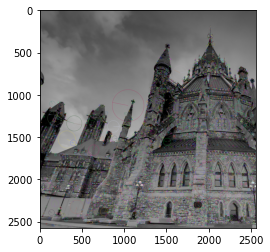

In [589]:
img=cv2.drawKeypoints(imgLeft_gr,kp_l,imgLeft,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
#cv2.imwrite('sift_keypoints.jpg',img)
plt.imshow(img)

In [590]:
kp_r, des_r = sift.detectAndCompute(imgRight_gr,None)

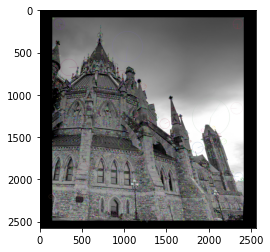

In [591]:
img=cv2.drawKeypoints(imgRight_gr,kp_r,imgRight,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
#cv2.imwrite('sift_keypoints.jpg',img)
plt.imshow(img)

In [592]:
des_l_k = kornia.image_to_tensor(des_l)

In [593]:
des_l_k.shape

torch.Size([1, 16538, 128])

In [594]:
des_l_k = torch.squeeze(des_l_k)

In [595]:
des_l_k.shape

torch.Size([16538, 128])

In [596]:
des_r_k = kornia.image_to_tensor(des_r)
des_r_k = torch.squeeze(des_r_k)

In [597]:
des_r_k.shape

torch.Size([17777, 128])

In [598]:
bf = cv2.BFMatcher()
dis = bf.knnMatch(des_l, des_r, k=2) 
matched1, matched2 = kornia.feature.match_snn(des_l_k, des_r_k)

In [599]:
matched1[0]

tensor([0.7627])

In [600]:
#Step 4, apply thresholding (using threshold = 50)
thresholded = []
for i, j in dis:
    if i.distance < 0.75*j.distance:
        if i.distance < 50:
            thresholded.append([i])
            #thresholded.append([i, matched1[0], matched2[0]])

In [601]:
# #Step 4, apply thresholding (for kornia matched values)
# thresh = []
# for i, j in matched2:
#     if i < 0.75*j:
#         if i < 50:
#             thresh.append([i])

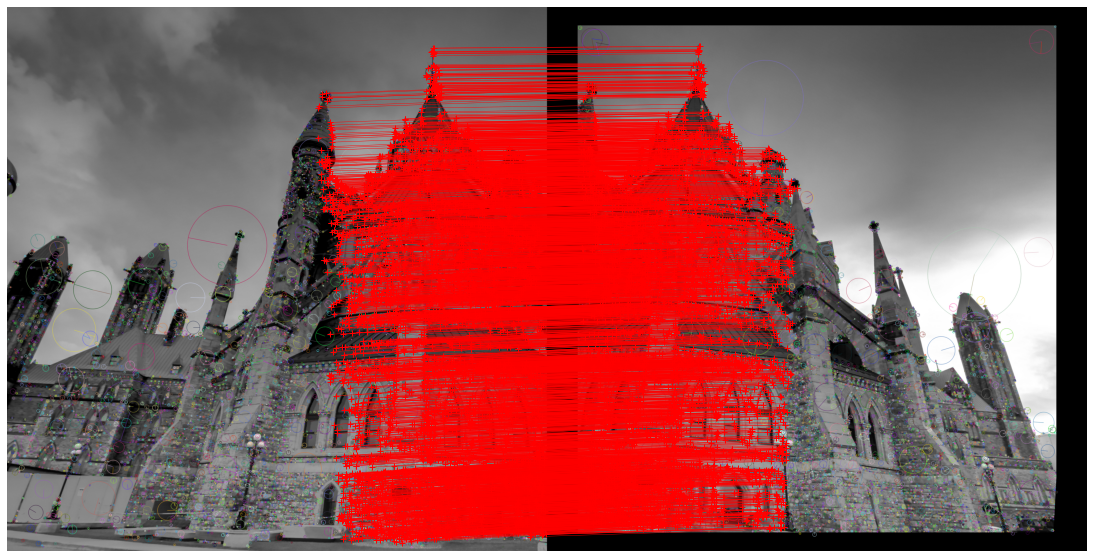

In [602]:
matched = []
for i in thresholded:
    imgLeft_Idx = i[0].queryIdx
    imgRight_Idx = i[0].trainIdx

    [a1,b1] = kp_l[imgLeft_Idx].pt
    [a2,b2] = kp_r[imgRight_Idx].pt
    matched.append([a1,b1,a2,b2])

matched = np.asarray(matched)

fig, ax = plt.subplots(figsize=(20,10))
plot_inlier_matches(ax, imgLeft, imgRight, matched)


In [603]:
len(matched)

3957

In [604]:
matched.shape

(3957, 4)

In [605]:
#Implement ransac

In [606]:
matched.shape[0]

3957

In [607]:
points = [random.randint(0,matched.shape[0]-1) for point in range(4)]

In [608]:
points

[1648, 2454, 2883, 2601]

In [609]:
fourStack = np.vstack((points[0], points[1]))
print(fourStack)
fourStack = np.vstack((fourStack, points[2]))
print(fourStack)
fourStack = np.vstack((fourStack, points[3]))
print(fourStack)

[[1648]
 [2454]]
[[1648]
 [2454]
 [2883]]
[[1648]
 [2454]
 [2883]
 [2601]]


In [610]:
otherStack = np.reshape(points, (4,1))
print(otherStack)

[[1648]
 [2454]
 [2883]
 [2601]]


In [611]:
np.matrix([otherStack[0],otherStack[1],1])

c:\Users\Jimmy Le\anaconda3\lib\site-packages\numpy\matrixlib\defmatrix.py:145: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = N.array(data, dtype=dtype, copy=copy)


matrix([[array([[1648]]), array([[2454]]), 1]], dtype=object)

In [614]:
bestModel = None
#bestScore = Math.inf 
bestInliers = []
inliers = []
#rand = random.randint(0, matched.shape[0]-1)
#For a sufficent number of iterations   
for i in range(2000):
    points = [random.randint(0,matched.shape[0]-1) for k in range(4)]
    h = homography(points)       
    #print(type(h))
    inliers = []

    for j in matched:
        d = geometricDistance(j,h)
        if d < 5:
            inliers.append(j)
    
    if len(inliers) > len(bestInliers):
        bestInliers = inliers
        bestModel = h

    if len(bestInliers) > (len(matched)*0.05):
        break

C:\Users\Jimmy Le\AppData\Local\Temp\ipykernel_9076\2789739806.py:13: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  matrix = np.asarray(matrix, dtype=float)


In [612]:
#h, inliers = RANSAC(matched,.05)

C:\Users\Jimmy Le\AppData\Local\Temp\ipykernel_9076\2789739806.py:13: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  matrix = np.asarray(matrix, dtype=float)


In [617]:
type(h)

numpy.ndarray

In [619]:
timg1 = kornia.utils.image_to_tensor(np.array(imgLeft), False).float() / 255.
timg2 = kornia.utils.image_to_tensor(np.array(imgRight), False).float() / 255.

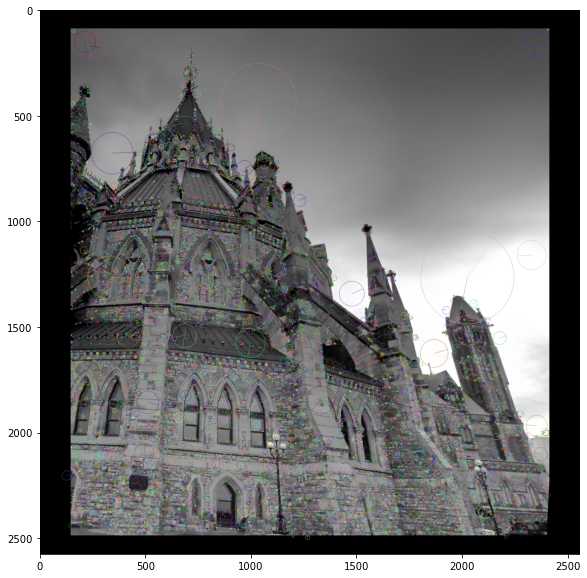

In [623]:
# 1) perform warping on image and visualize overlapping pair
t = torch.tensor(h, dtype = torch.float)
t = t.unsqueeze(0)
_,_,height,width = timg1.shape
out = kornia.geometry.warp_perspective(timg1,t,(height,width))
maximum = torch.max(out,timg2)
maximum = kornia.color.bgr_to_rgb(maximum) 
plt.figure(figsize=(20,10))
plt.imshow(kornia.utils.tensor_to_image(maximum))